## Chatbot 
- GPU Environment 
- Transformer code refer to node


In [1]:
import os 
import re
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

### 1. Dataset

In [3]:
data_path = os.getcwd() + '/data/ChatbotData.csv'

data = pd.read_csv(data_path)
data.head()


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [55]:
# preprocessing text -> dataframe 기준 전처리 function 

def preprocess_text(df):
    df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(lambda x: x.str.strip())
    df = df.replace(r"([?.!,])", r" \1 ", regex = True)
    df = df.replace('(([!.,*^])\\2{1,})', '', regex = True) # 연속된 같은 문자 변환 (2개이상)
    df = df.replace('[" "]+', " ", regex = True) # 공백 2개 이상시 한개로 변환
    df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(lambda x: x.str.strip())
    return df
    

In [67]:
# List 기준 전처리 fuction 

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'(([!.,*^])\\2{1,})', '', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [56]:
# data는 df 형식이기 때문 preprocess_text 사용 

data = preprocess_text(data)

#### 데이터 중복값 처리 

In [7]:
# 겹치는 행 있는지 check 
data[['Q', 'A']].describe()
# data.describe()

,Q,A
count,11823,11823
unique,11662,7779
top,외로워,맛있게 드세요 .
freq,4,22


In [8]:
# 전체 데이터로는 중복값 없음 
print(data.duplicated().sum())

# 라벨을 제외한 데이터로 확인하면 73개 존재 
print(data.duplicated(['Q', 'A']).sum())

# 중복값 중 처음꺼 remain 
data_m = data.drop_duplicates(['Q', 'A'], inplace = False)
data_m.info()

0
73
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11750 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11750 non-null  object
 1   A       11750 non-null  object
 2   label   11750 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 367.2+ KB


In [9]:
# 중복값 없는 것 확인 

print(data_m.duplicated(['Q', 'A']).sum())

0


In [10]:
# question 평균 length 파악 
print(data.iloc[:, 0].apply(len).mean())
print(data.iloc[:, 0].apply(len).max())
print(data.iloc[:, 0].apply(len).min())

# answer 평균 length 파악 
print(data.iloc[:, 1].apply(len).mean())
print(data.iloc[:, 1].apply(len).max())
print(data.iloc[:, 1].apply(len).min())

# 이건 str 한 단어가 아닌 한 음절(?)의 길이를 의미함 max_sample 설정에 필요한 정보ok 

q_w_len = data.iloc[:, 0].apply(len)
a_w_len = data.iloc[:, 1].apply(len)

# print(q_w_len, a_w_len)

13.231920832276073
57
1
16.037384758521526
78
1


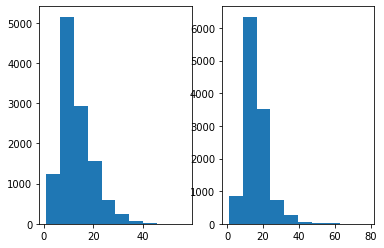

In [11]:
plt.subplot(121)
plt.hist(q_w_len)

plt.subplot(122)
plt.hist(a_w_len)
plt.show()

# max_sample은 20으로 설정하고자 함 

In [12]:
# 데이터 question, answer 각 각 리스트화 
MAX_SAMPLES = 25

def get_text_as_list(data):
    inputs, outputs = [], []
    
    for input in data.iloc[:, 0]:
        inputs.append(input)
    for output in data.iloc[:, 1]:
        outputs.append(output)
    
    if len(input) <= MAX_SAMPLES:
        return inputs, outputs
    

In [13]:
questions, answers = get_text_as_list(data)

In [14]:
# list data 확인 
questions[:5]

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

In [15]:
# len 동일한지 재 확인 

print(len(questions), len(answers))

11823 11823


### 2. Tokenizing 

In [16]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# tf.__version__ over 2.3.0
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [17]:
# tf.__version__ under 2.3.0
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [18]:
tokenizer

<SubwordTextEncoder vocab_size=8173>

In [19]:
# 토크나이저 결과 vocab size 확인
# 해당 size 이후 number로 start token, end token 설정할 예정 
tokenizer.vocab_size

8173

#### input, output 문장 구분 str 입력

In [20]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print(START_TOKEN, END_TOKEN)

[8173] [8174]


In [21]:
# 전체 vocab size 설정 
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [22]:
# str -> int 인코더 결과 test 확인

print(tokenizer.encode(questions[0]), questions[0])
print(tokenizer.encode(questions[1]), questions[1])

[7912, 4204, 3056, 41] 12시 땡 !
[7966, 47, 918, 7949, 997, 1715] 1지망 학교 떨어졌어


In [71]:
# 거꾸로로도 확인 

tokenizer.decode([7912, 4204, 3056, 41])

# tokenizer.decode([8173] # 얘는 처음부터 


'12시 땡 !'

In [23]:
# start & end token 추가 및 Padding 

def tokenize_and_padding(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (text1, text2) in zip(inputs, outputs):
        text1 = START_TOKEN + tokenizer.encode(text1) + END_TOKEN
        text2 = START_TOKEN + tokenizer.encode(text2) + END_TOKEN
        
        if len(text1) <= MAX_SAMPLES and len(text2) <= MAX_SAMPLES:
            tokenized_inputs.append(text1)
            tokenized_outputs.append(text2)
            
    # MAX_SAMPLE에 맞춰서 padding 
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                tokenized_inputs, maxlen = MAX_SAMPLES, padding = 'post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                tokenized_outputs, maxlen = MAX_SAMPLES, padding = 'post')
    
    return tokenized_inputs, tokenized_outputs
        

In [24]:
# question, answer에 앞뒤token 추가한 뒤 padding 

questions, answers = tokenize_and_padding(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

# 기존 데이터와 몇개 차이나지 않음 

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


### 3. Transformer | Encoder & Decoder Function
RNN을 사용하지 않고, Attention을 여러 레이어에서 반복함   


1. Encoder
- Input Embedding Matrix : 입력값 embedding. embedding dim은 임의로 설정(논문에서는 512로 세팅) 
- Positional Encoding : 위치정보 포함시킴
- Multihead Attention : Input Embedding + Positional Encoding 
    - 입력 문장에 대한 정보(input embedding) + 위치정보(positional)된 입력정보를 얻게 됨 
    - 입력받아서 각 단어 이용해서 Self-Attention 수행 
    - 각 단어가 서로에게 어떤 relation이 있는지 확인. 문맥정보 주는것
- Add + Norm : Residual Learing 진행한 값까지 받아서 Normalize까지 해줌
    - positional encoding된 정보를 multihead를 뛰어 넘어서 추가적으로 잔여된 부분만 추가적으로 학습시킴   
    

- Encoder 정리 
    - Encoder 한 레이어에 input embedding - positional encoding - multihead attention - add+norm - feedforward layer - add + norm 이 진행됨 
    - Attention과 Normalize 과정을 반복 
    - 각 레이어는 서로 다른 파라미터 가짐 
    - Encoder의 마지막 출력값은 Decoder에 input으로 들어감 
    - Decoder는 출력할 때마다 입력소스 문장 중에서 어떤 단어에게 가장 많은 초점을 둬야하는지 알려줘야 하기 때문 
    
    
2. Decoder 
- Encoder 마지막 출력값을 받아서 Output Embedding Matrix를 통해서, Positional Encoding으로 상대적인 위치 정보를 알려주기 위해 encoder 값 추가한 후에 입력 넣게 됨 
- 2개의 MultiheadAttention 사용. 
    1) 처음 것이 SELF ATTENTION : 단어들끼리 서로가 서로에게 어떤 가중치를 갖고있는지 확인하게 해서 출력되고 있는 문장에 대한 전반적인 표현을 학습할 수 있게 만듦(인코더 어탠션과 동일함)
    2) 두번쨰 Attention : 인코더의 출력 정보를 받아와서 사용. 각 출력 단어가 소스문장에서의 어떤 단어와 관련이 있는지 확인. Encoder Decoder Attention이라 해. 
- END TOKEN이 나올떄까지 Decoder를 이용 


3. MultiheadAttention
- ScaledDotProductAttention을 사용함 
- Attention을 위해서 Q, K, V가 필요함 
- 쿼리는 물어보는 주체, 물어보는 대상이 key(I라는 쿼리 단어가 i am a teacher(각각이 key야) 각각에 대해서 얼마나 연관성이 있는지 구하고자 하는 것) 
- key는 attention을 수행할 단어들을 의미함 
- Q와 K를 Matmul -> Scale -> Mask -> softmax 통과해 값을 얻고, V과 그 결과값을 MatMul 
- 나온 V, K, Q값은 linear 즉, 행렬곱을 수행해서 서로 다른 h개의 scaled dot product attention으로 각 각 들어감 
- h개의 서로 다른 v, k, q를 얻는 것이지 
- 그리고 그 결과를 concat해서 input값과 output값이 같은 차원으로 나오도록 처리하고 
- linear 을 통해서 결과값을 내보냄 


4. Mask matrix
- Attention Energy와 Mask Matrix를 곱해서 마스크를 적용시켜서 특정 단어는 attention을 적용시키지 않게 진행함 

#### 위치정보 제공하는 PositionalEncoding func.


In [25]:

class PositionalEncoding(tf.keras.layers.Layer): # tf.keras.layers.Layer 메소드를 상속받겠다 

    def __init__(self, position, d_model): # d_model은 임베딩 차원 
        super(PositionalEncoding, self).__init__() # super : 자식 클래스에서 부모클래스의 내용을 사용할 때 사용 
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model): 
        angles = 1 / tf.pow(10000, (2* (i //2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성 
        angle_rads = self.get_angles(
                    position = tf.range(position, dtype = tf.float32)[:, tf.newaxis], #position값까지 숫자 생성. newaxis로 차원 변경 
                    i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :], 
                    d_model = d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용. 주기성 학습하기위해 사용 
        sines = tf.math.sin(angle_rads[:, 0::2]) 
        # 배열의 홀수 인덱스에는 cosine 함수 적용 
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열 
        pos_encoding = tf.stack([sines, cosines], axis = 0)
        pos_encoding = tf.transpose(pos_encoding, [1,2,0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


***[TIP]***  

1. arr[a:b:c] : index a부터 index b까지 c의 간격으로 배열을 생성해라  

    a가 none 이면 처음부터, b가 none이면 할수있는데까지(c가 양수면 마지막index까지, c가 음수면 첫 index까지), c가 none이면 한칸 간격으로  

2. tf.pow(x, y) : x 값에 y 거듭제곱  

3. tf.cast(a, b) : a를 b형태로 변경해라 (boolean인데 int로 바꾼다면 0과 1로 바꾼다)  

4. tf.range(limit, delta, dtype, name) / tf.range(start, limit, delta, dtype, name)  

5. train_x [..., tf.newaxis]

    이 방법은 [] 안에 기존의 배열을...으로 적고, 추가하고 싶은 위치에 tf.newaxis를 적어주면 간단히 size 변경이 됨  


In [26]:
# 스케일드 닷 프로덕트 어텐션 함수 


def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트 
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # 가중치를 정규화 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가 
    if mask is not None:
        logits += (mask * -1e9)
    
    # softmax 적용
    attention_weights = tf.nn.softmax(logits, axis = -1)

    # 최종 attention은 가중치와 V의 닷 프로덕트 
    output = tf.matmul(attention_weights, value)
    return output

In [27]:
# 계산효율성을 위해 head 개수만큼 나눠서 계산 후 concat

class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0 # assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.

        self.depth = d_model // self.num_heads # 차원을 병렬개수로 나눠서 depth를 얻어 

        self.query_dense = tf.keras.layers.Dense(units=d_model) 
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) #  (x.shape[0], x.shape[2], x.shape[1], x.shape[3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


In [28]:
# padding masking
def create_padding_mask(x):
    # 정수 시퀀스에서 0인 경우에는 1(True니까)로 변환하고, 그렇지 않은 경우에는 0(False)으로 변환하는 함수
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :] # 4차원으로 변경하겠다 


***[TIP]***  

`tf.math.equal(x, y, name=None)` : Returns the truth value of (x == y) element-wise.

In [29]:
# 룩어헤드마스크

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 가장 안쪽의 각 행렬에서 중앙 밴드 외부의 모든 것을 0으로 설정하는 텐서를 복사
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # tf.linalg의 값을 반대로 
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# # padding masking
# def create_padding_mask(x):
#     # 정수 시퀀스에서 0인 경우에는 1(True니까)로 변환하고, 그렇지 않은 경우에는 0(False)으로 변환하는 함수
#     mask = tf.cast(tf.math.equal(x, 0), tf.float32)
#     # (batch_size, 1, 1, sequence length)
#     return mask[:, tf.newaxis, tf.newaxis, :]


# tf.linalg.band_part(input, num_lower, num_upper, name=None)
# num_lower is lower bound of number and num_upper is upper bound of number
# we want to keep number for a matrix in a range num_lower to num upper and 
# if the number of matrix not fall at this range then this api makes it 0
# Now this tensorflow api only do this work upper triangular region of matrix 
# and lower triangular region of this matrix
# If the num_lower is less than num_upper then it applies for lower triangular matrix
# and if num_lower is greater than num upper then it applies upper triangular of matrix

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.

def encoder_layer(units, d_model, num_heads, dropout, name = 'encoder_layer'):
    inputs = tf.keras.Input(shape = (None, d_model), name = 'inputs')

    # 패딩 마스크 사용 
    padding_mask = tf.keras.Input(shape = (1,1,None), name = 'padding_mask')

    # 첫번째 서브 레이어: 멀티 헤드 어텐션 수행(셀프어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name = 'attention')({
            'query' : inputs, 
            'key' : inputs, 
            'value' : inputs, 
            'mask' : padding_mask
        })
    
    # 어텐션의 결과는 dropout과 layer normalization이라는 훈련을 돕는 테크닉을 수행 
    attention = tf.keras.layers.Dropout(rate = dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전 연결층 
    outputs = tf.keras.layers.Dense(units = units, activation = 'relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 완전연결층의 결과는 dropout과 layerNormalization이라는 훈련을 돕는 테크닉을 수행 
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs = [inputs, padding_mask], outputs = outputs, name = name)
    

In [31]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### Model 구성 

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# question이 input, answer이 output
# output에서는 start token 제거. 디코더는 인코더의 결과를 사용하기 때문

dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions,'dec_inputs': answers[:, :-1]},
    {'outputs': answers[:, 1:]},
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


tf.data.experimental.AUTOTUNE으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정

In [35]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 25), dec_inputs: (None, 24)}, {outputs: (None, 24)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
    # 내부적으로 패딩 마스크도 포함되어 있음 
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3147008     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [43]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_SAMPLES - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [39]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

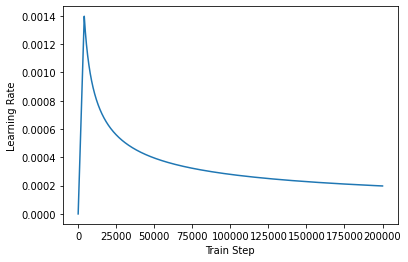

In [44]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [47]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_SAMPLES - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [73]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 18s 95ms/step - loss: 0.0687 - accuracy: 0.2677
Epoch 2/50
185/185 [==============================] - 18s 98ms/step - loss: 0.0655 - accuracy: 0.2680
Epoch 3/50
185/185 [==============================] - 18s 98ms/step - loss: 0.0597 - accuracy: 0.2694
Epoch 4/50
185/185 [==============================] - 19s 101ms/step - loss: 0.0511 - accuracy: 0.2715
Epoch 5/50
185/185 [==============================] - 19s 101ms/step - loss: 0.0449 - accuracy: 0.2729
Epoch 6/50
185/185 [==============================] - 19s 102ms/step - loss: 0.0408 - accuracy: 0.2740
Epoch 7/50
185/185 [==============================] - 19s 101ms/step - loss: 0.0354 - accuracy: 0.2753
Epoch 8/50
185/185 [==============================] - 19s 103ms/step - loss: 0.0336 - accuracy: 0.2759
Epoch 9/50
185/185 [==============================] - 19s 101ms/step - loss: 0.0297 - accuracy: 0.2766
Epoch 10/50
185/185 [==============================] - 19s 102ms/step - loss

### 결과확인

In [61]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
# preprocessing text 

def preprocess_text(df):
    df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(lambda x: x.str.strip())
    df = df.replace(r"([?.!,])", r" \1 ", regex = True)
    df = df.replace('(([!.,*^])\\2{1,})', '', regex = True) # 연속된 같은 문자 변환 (2개이상)
    df = df.replace('[" "]+', " ", regex = True) # 공백 2개 이상시 한개로 변환
    df.iloc[:, 0:2] = df.iloc[:, 0:2].apply(lambda x: x.str.strip())
    return df
    

In [74]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_SAMPLES):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됨
        # 이 output_sequence는 다시 디코더에 입력됨
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [75]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [76]:
sentence_generation('좋아하는 애한테 뭐하자고 물어볼까?')

입력 : 좋아하는 애한테 뭐하자고 물어볼까?
출력 : 저랑 놀아요 .


'저랑 놀아요 .'

In [77]:
sentence_generation('고백 어떻게해?')

입력 : 고백 어떻게해?
출력 : 먼저 고백하는 것도 좋지만 슬쩍 호감을 표현해보세요 .


'먼저 고백하는 것도 좋지만 슬쩍 호감을 표현해보세요 .'

In [78]:
sentence_generation('배고파')

입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

In [82]:
sentence_generation('스트레스 많을 때 어떻게 해?')

입력 : 스트레스 많을 때 어떻게 해?
출력 : 운동을 해보세요 .


'운동을 해보세요 .'

### 회고 
- 코드를 쪼개는데 약간의 무리가 있음. 공부가 더 필요함
- epoch를 늘려서 진행해본 결과 epoch = 20보다는, epoch = 50이 훨신 더 나아지는 결과를 보여줌 